In [1]:
import pandas as pd
import os, sys

## AF Feats

In [2]:
fname = '/scratch/elec/puhe/c/muse_2023/c3_muse_personalisation/feature_segments/w2v-msp/10.csv'
df = pd.read_csv(fname)
df.shape

(588, 1026)

## Physio-Arousal, Valence

<Axes: title={'center': 'physio-arousal'}>

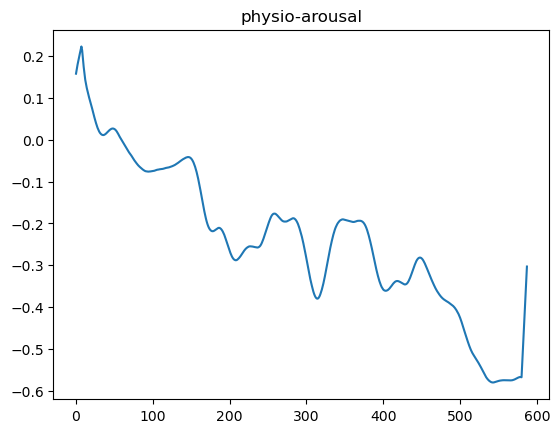

In [26]:
affect='physio-arousal' # 'valence'
fname = f'/scratch/elec/puhe/c/muse_2023/c3_muse_personalisation/label_segments/{affect}/10.csv'
df = pd.read_csv(fname)
df.shape
df.head(3)
df['value'].plot(title=affect)

## Biosignals

<Axes: title={'center': 'resp'}>

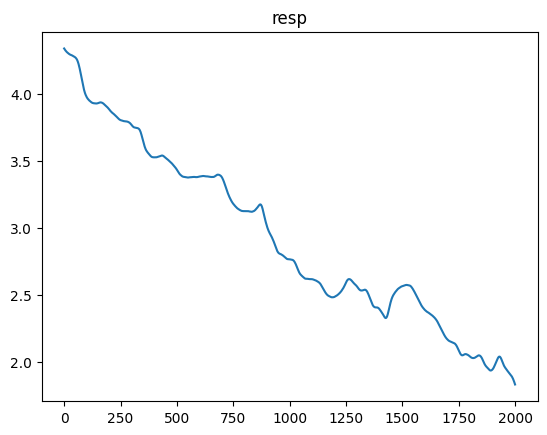

In [6]:
bio='resp'
fname = f'/scratch/elec/puhe/c/muse_2023/c3_muse_personalisation/feature_segments/{bio}_raw/10.csv'
df = pd.read_csv(fname)
df[bio][:2000,].plot(title=bio)

<Axes: title={'center': 'resp'}>

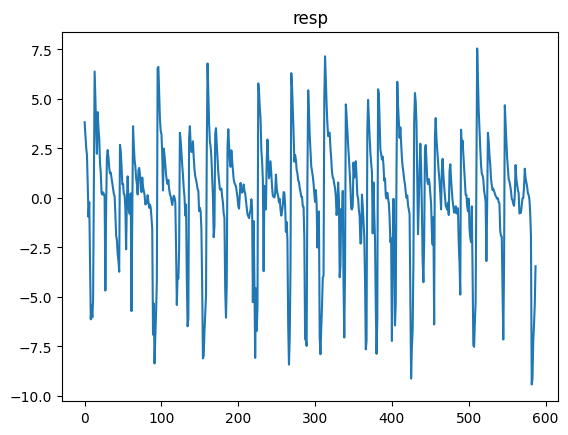

In [10]:
bio='resp'
fname = f'/scratch/elec/puhe/c/muse_2023/c3_muse_personalisation/feature_segments/{bio}/10.csv'
df = pd.read_csv(fname)
df[bio][:2000,].plot(title=bio)

<Axes: title={'center': 'resp'}>

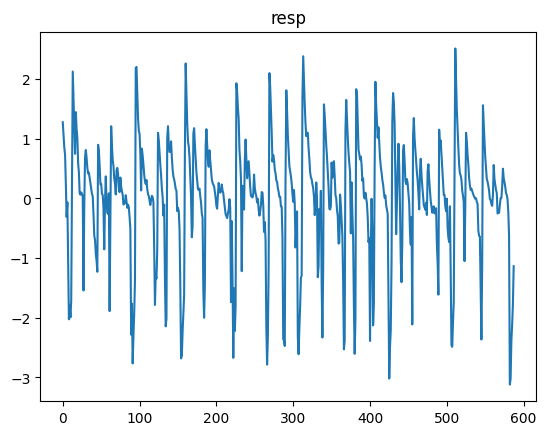

In [13]:
bio='resp'
fname = f'/scratch/elec/puhe/c/muse_2023/c3_muse_personalisation/label_segments/{bio}_normalized/10.csv'
df = pd.read_csv(fname)
df['value'][:2000,].plot(title=bio)